
# Producing single subject maps of seed-to-voxel correlation

This example shows how to produce seed-to-:term:`voxel` correlation maps
for a single subject based on movie-watching :term:`fMRI` scans.
These maps depict the temporal correlation of a **seed region** with the
**rest of the brain**.

This example is an advanced one that requires manipulating the data with numpy.
Note the difference between images, that lie in brain space, and the
numpy array, corresponding to the data inside the mask.

See also `for a similar example using cortical surface input data
<sphx_glr_auto_examples_01_plotting_plot_surf_stat_map.py>`.

Author: Franz Liem

.. include:: ../../../examples/masker_note.rst


## Getting the data

We will work with the first subject
of the brain development :term:`fMRI` data set.
dataset.func is a list of filenames. We select the 1st (0-based)
subject by indexing with [0]).



In [ ]:
from nilearn import datasets, plotting

dataset = datasets.fetch_development_fmri(n_subjects=1)
func_filename = dataset.func[0]
confound_filename = dataset.confounds[0]

Note that func_filename and confound_filename are strings pointing to
files on your hard drive.



In [ ]:
print(func_filename)
print(confound_filename)

## Time series extraction

We are going to extract signals from the functional time series in two
steps. First we will extract the mean signal within the **seed region of
interest**.
Second, we will extract the **brain-wide voxel-wise time series**.

We will be working with one seed sphere in the Posterior Cingulate Cortex
(PCC), considered part of the Default Mode Network.



In [ ]:
pcc_coords = [(0, -52, 18)]

We use :class:`nilearn.maskers.NiftiSpheresMasker` to extract the
**time series from the functional imaging within the sphere**. The
sphere is centered at pcc_coords and will have the radius we pass the
NiftiSpheresMasker function (here 8 mm).

The extraction will also detrend, standardize, and bandpass filter the data.
This will create a NiftiSpheresMasker object.



In [ ]:
from nilearn.maskers import NiftiSpheresMasker

seed_masker = NiftiSpheresMasker(
    pcc_coords,
    radius=8,
    detrend=True,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    low_pass=0.1,
    high_pass=0.01,
    t_r=2,
    memory="nilearn_cache",
    memory_level=1,
    verbose=0,
)

Then we extract the mean time series within the seed region while
regressing out the confounds that
can be found in the dataset's csv file



In [ ]:
seed_time_series = seed_masker.fit_transform(
    func_filename, confounds=[confound_filename]
)

Next, we can proceed similarly for the **brain-wide voxel-wise time
series**, using :class:`nilearn.maskers.NiftiMasker` with the same input
arguments as in the seed_masker in addition to smoothing with a 6 mm kernel



In [ ]:
from nilearn.maskers import NiftiMasker

brain_masker = NiftiMasker(
    smoothing_fwhm=6,
    detrend=True,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    low_pass=0.1,
    high_pass=0.01,
    t_r=2,
    memory="nilearn_cache",
    memory_level=1,
    verbose=0,
)

Then we extract the brain-wide voxel-wise time series while regressing
out the confounds as before



In [ ]:
brain_time_series = brain_masker.fit_transform(
    func_filename, confounds=[confound_filename]
)

We can now inspect the extracted time series. Note that the **seed time
series** is an array with shape n_volumes, 1), while the
**brain time series** is an array with shape (n_volumes, n_voxels).



In [ ]:
print(f"Seed time series shape: ({seed_time_series.shape})")
print(f"Brain time series shape: ({brain_time_series.shape})")

We can plot the **seed time series**.



In [ ]:
import matplotlib.pyplot as plt

plt.plot(seed_time_series)
plt.title("Seed time series (Posterior cingulate cortex)")
plt.xlabel("Scan number")
plt.ylabel("Normalized signal")
plt.tight_layout()

Exemplarily, we can also select 5 random voxels from the **brain-wide
data** and plot the time series from.



In [ ]:
plt.plot(brain_time_series[:, [10, 45, 100, 5000, 10000]])
plt.title("Time series from 5 random voxels")
plt.xlabel("Scan number")
plt.ylabel("Normalized signal")
plt.tight_layout()

## Performing the seed-to-voxel correlation analysis

Now that we have two arrays (**sphere signal**: (n_volumes, 1),
**brain-wide voxel-wise signal** (n_volumes, n_voxels)), we can correlate
the **seed signal** with the **signal of each voxel**. The dot product of
the two arrays will give us this correlation. Note that the signals have
been variance-standardized during extraction. To have them standardized to
norm unit, we further have to divide the result by the length of the time
series.



In [ ]:
import numpy as np

seed_to_voxel_correlations = (
    np.dot(brain_time_series.T, seed_time_series) / seed_time_series.shape[0]
)

The resulting array will contain a value representing the correlation
values between the signal in the **seed region** of interest and **each
voxel's signal**, and will be of shape (n_voxels, 1). The correlation
values can potentially range between -1 and 1.



In [ ]:
print(
    "Seed-to-voxel correlation shape: (%s, %s)"
    % seed_to_voxel_correlations.shape
)
print(
    "Seed-to-voxel correlation: min = %.3f; max = %.3f"
    % (seed_to_voxel_correlations.min(), seed_to_voxel_correlations.max())
)

## Plotting the seed-to-voxel correlation map
We can now plot the seed-to-voxel correlation map and perform thresholding
to only show values more extreme than +/- 0.5. Before displaying,
we need to create an in memory Nifti image object.
Furthermore, we can display the location of the seed with a sphere and
set the cross to the center of the seed region of interest.



In [ ]:
seed_to_voxel_correlations_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations.T
)
display = plotting.plot_stat_map(
    seed_to_voxel_correlations_img,
    threshold=0.5,
    vmax=1,
    cut_coords=pcc_coords[0],
    title="Seed-to-voxel correlation (PCC seed)",
)
display.add_markers(
    marker_coords=pcc_coords, marker_color="g", marker_size=300
)
# At last, we save the plot as pdf.
from pathlib import Path

output_dir = Path.cwd() / "results" / "plot_seed_to_voxel_correlation"
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")

display.savefig(output_dir / "pcc_seed_correlation.pdf")

## Fisher-z transformation and save nifti
Finally, we can Fisher-z transform the data to achieve a normal distribution.
The transformed array can now have values more extreme than +/- 1.



In [ ]:
seed_to_voxel_correlations_fisher_z = np.arctanh(seed_to_voxel_correlations)
print(
    "Seed-to-voxel correlation Fisher-z transformed: "
    f"min = {seed_to_voxel_correlations_fisher_z.min():.3f}; "
    f"max = {seed_to_voxel_correlations_fisher_z.max():.3f}f"
)

Eventually, we can transform the correlation array back to a Nifti image
object, that we can save.



In [ ]:
seed_to_voxel_correlations_fisher_z_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations_fisher_z.T
)
seed_to_voxel_correlations_fisher_z_img.to_filename(
    output_dir / "pcc_seed_correlation_z.nii.gz"
)

# One-smaple t-test

In [55]:
import os
import numpy as np
import nibabel as nib
import scipy
input_dir = rf" "
mask_file = rf"tpl-MNI152NLin6Asym_res-02_desc-brain_mask.nii.gz"

mask = nib.load(mask_file)
mask_shape = mask.shape
mask_data = mask.get_fdata()
mask_data[mask_data != 0] = 1
subject_data = np.zeros((mask_shape[0]*mask_shape[1]*mask_shape[2],len(os.listdir(input_dir))),np.float32)

for index,subject in enumerate(os.listdir(input_dir)):
    
    subject_filename = os.path.join(input_dir, subject)
    fdata = nib.load(subject_filename).get_fdata()
    subject_data[:,index] = np.reshape(fdata,newshape=(mask_shape[0]*mask_shape[1]*mask_shape[2]))
    
one_sample_results = scipy.stats.ttest_1samp(subject_data.T,0).statistic
reshape_one_sample_results = np.reshape(one_sample_results, newshape=(mask_shape[0], mask_shape[1], mask_shape[2]))


### we can transform the one-sample t-value to t-map

In [56]:
output_dir = rf" "
masked_nifti = nib.Nifti1Image(reshape_one_sample_results*mask_data, mask.affine, mask.header)
nib.save(masked_nifti,filename=os.path.join(output_dir,'t_map.nii.gz'))

# Overlapping section

###  First, each experiment-level t-map was thresholded at t > (?)


In [79]:
thresholded = 3
input_dir = rf" "
thresholded_data = np.zeros((mask_shape[0], mask_shape[1], mask_shape[2], len(os.listdir(input_dir))), np.int16)
for index,tmap in enumerate(os.listdir(input_dir)):
    
    tmap_filename = os.path.join(input_dir, tmap)
    
    tvalue = nib.load(tmap_filename).get_fdata()
    tvalue_new = tvalue.copy()
    
    tvalue_new[tvalue>thresholded] = 1
    tvalue_new[tvalue<thresholded] = 0
    
    thresholded_data[:,:,:,index] = tvalue_new


###  Second, all binarized maps were overlapped and thresholded at 60% to create a group-level network overlap map

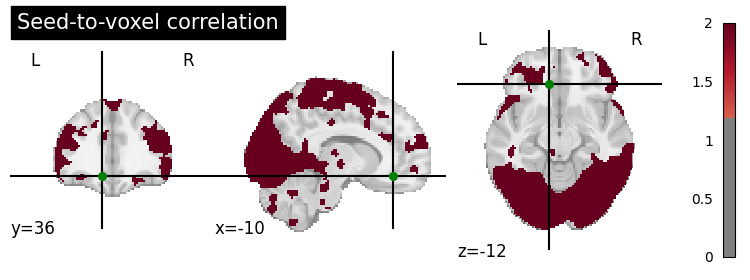

In [95]:

overlap = np.sum(thresholded_data,axis=3)
show_thresholded = 0.6

vmax = np.max(overlap)
threshold = vmax*show_thresholded

import nibabel as nib
from nilearn import plotting

atlas_filename = rf"D:\GitRepository\nmda\Output\tpl-MNI152NLin6Asym_res-02_desc-brain_mask.nii.gz"
mask = nib.load(atlas_filename)
mask_data = mask.get_fdata()
mask_data[mask_data!=0] = 1
overlap_img = nib.Nifti1Image(overlap, mask.affine, mask.header)



coords = [(-10,  36, -12)]

display = plotting.plot_stat_map(
    overlap_img,
    threshold=threshold,
    vmax=vmax,
    cut_coords=coords[0],
    title="Overlapped map",
    resampling_interpolation='nearest',
    cmap='RdBu_r'
)
display.add_markers(
    marker_coords=coords, marker_color="g", marker_size=30
)

### Finally, save the overlap map

In [91]:
output_filename = rf"overlap.nii.gz"
nib.save(overlap_img,output_filename)

2